In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
def promedio(lst):
    return (sum(lst)/len(lst))

def desvioEstandar(lst):
    prom = promedio(lst)
    return (sum([(x-prom)**2 for x in lst])/len(lst))**0.5

# www.harvard.edu

In [5]:
dfAllHops = pd.read_csv("experimentos/www.harvard.edu-allHops.csv", sep=",")

with open('experimentos/www.harvard.edu-ips.csv') as csv:
    lstIps = csv.readlines()
lstIps = [s[:len(s)-1] for s in lstIps]

with open('experimentos/www.harvard.edu-rtt.csv') as csv:
    lstRtt = csv.readlines()
lstRtt = [float(s[:len(s)-1]) for s in lstRtt]

with open('experimentos/www.harvard.edu-salto.csv') as csv:
    lstSaltos = csv.readlines()
lstSaltos = [s[:len(s)-1] for s in lstSaltos]

## RTT entre saltos (restar los valores promediados a cada salto)

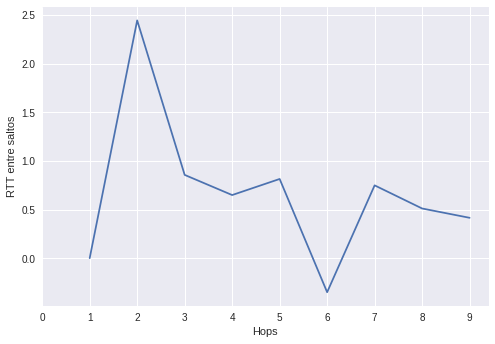

In [9]:
lstProm = [promedio(lstRtt[:i+1]) for i in range(len(lstRtt))]
lstRttEntreSaltos = [lstRtt[i]-lstProm[i] for i in range(len(lstRtt))]
lstX = range(1,len(lstRtt)+1)

plt.plot(lstX, lstRttEntreSaltos)
plt.ylabel('RTT entre saltos')
plt.xlabel('Hops')
plt.xticks(range(len(lstRttEntreSaltos)+1), range(len(lstRttEntreSaltos)+1))
plt.show()

## RTT entre saltos en la ruta, graficar el valor (X i − X̄)/S

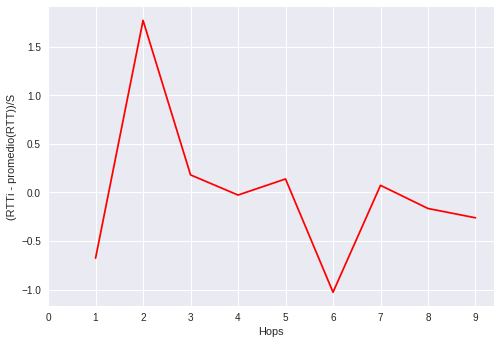

In [14]:
prom = promedio(lstRttEntreSaltos)
s = desvioEstandar(lstRttEntreSaltos)
lstVal = [(x-prom) for x in lstRttEntreSaltos]
lstX = range(1,len(lstRttEntreSaltos)+1)

plt.plot(lstX, lstVal, 'red')
plt.ylabel('(RTTi - promedio(RTT))/S')
plt.xlabel('Hops')
plt.xticks(range(len(lstX)+1), range(len(lstX)+1))
plt.show()

## Porcentaje que no responden los Time exceeded

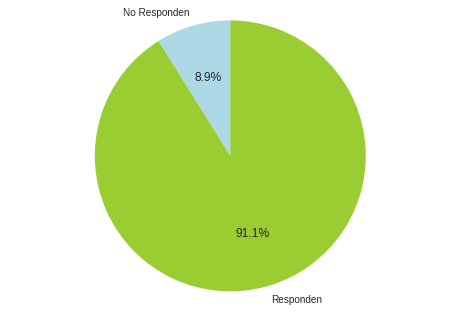

In [8]:
lstAllHops = dfAllHops['salto_intercontinental']
cantNull = 0
for ip in lstAllHops:
    if ip == 'null':
        cantNull+=1

porcentajes = [cantNull, len(lstAllHops) - cantNull]

labels = 'No Responden', 'Responden'
explode = [0,0]

fig1, ax1 = plt.subplots()
ax1.pie(porcentajes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['lightblue', 'yellowgreen'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Saltos Internacionales